In [ ]:
import os 
import sys
sys.path.append('/home/lytq/Spatial-Transcriptomics-Benchmark/DeepST/DeepST-main/deepst')
from DeepST import run
import matplotlib.pyplot as plt
from pathlib import Path
import scanpy as sc

import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings('ignore')

data_path = "/home/lytq/Spatial-Transcriptomics-Benchmark/data" 
data_name = "Mouse_Olfactory_Bulb"
save_path = "/home/lytq/Spatial-Transcriptomics-Benchmark/Results/results3/Mouse_Olfactory_Bulb/DeepST" 
os.makedirs(save_path, exist_ok=True)
n_domains = 7 

deepen = run(save_path = save_path,
	task = "Identify_Domain", 
	pre_epochs = 800, 
	epochs = 1000, 
	use_gpu = True)

###### Read in other spatial data, or user can read in themselves. Including original expression
###### information and spatial location information, where the location information is saved in .obsm["spatial"]
# adata = deepen._get_adata(platform="stereoSeq", data_path=data_path, data_name=data_name)
data_root = Path("/home/lytq/Spatial-Transcriptomics-Benchmark/data/Mouse_Olfactory_Bulb/")
if not os.path.exists(data_root / 'raw.h5ad'):
    counts = pd.read_csv(data_root / 'RNA_counts.tsv.gz', sep='\t', index_col=0).T
    counts.index = [f'Spot_{i}' for i in counts.index]
    adata = sc.AnnData(counts)
    adata.X = csr_matrix(adata.X, dtype=np.float32)

    df_pos = pd.read_csv(data_root / 'position.tsv', sep='\t')
    adata.obsm['spatial'] = df_pos[['y','x']].values

    used_barcode = pd.read_csv(os.path.join(data_root / 'used_barcodes.txt'), sep='\t', header=None)
    used_barcode = used_barcode[0]
    adata = adata[used_barcode,]

    adata.write( data_root / 'raw.h5ad')
else:
    adata = sc.read_h5ad( data_root / 'raw.h5ad')

###### Data augmentation. spatial_type includes three kinds of "KDTree", "BallTree" and "LinearRegress", among which "LinearRegress"
###### is only applicable to 10x visium and the remaining omics selects the other two.
###### "use_morphological" defines whether to use morphological images.
adata = deepen._get_augment(adata, spatial_type="BallTree", use_morphological=False)

###### Build graphs. "distType" includes "KDTree", "BallTree", "kneighbors_graph", "Radius", etc., see adj.py
graph_dict = deepen._get_graph(adata.obsm["spatial"], distType = "BallTree")

###### Enhanced data preprocessing
data = deepen._data_process(adata, pca_n_comps = 200)

###### Training models
deepst_embed = deepen._fit(
		data = data,
		graph_dict = graph_dict,)
###### DeepST outputs
adata.obsm["DeepST_embed"] = deepst_embed

###### Define the number of space domains, and the model can also be customized. If it is a model custom priori = False.
adata = deepen._get_cluster_data(adata, n_domains=n_domains, priori = True)

In [3]:
adata = deepen._get_cluster_data(adata, n_domains=n_domains, priori = True)

Best resolution:  0.3999999999999998


In [4]:
print(adata)
print(adata.obs['DeepST_refine_domain'])
print(adata.obs['DeepST_refine_domain'].value_counts())
print(adata.obs['DeepST_domain'])
print(adata.obs['leiden'])
print(adata.obs['leiden'].value_counts())

AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'leiden', 'DeepST_domain', 'DeepST_refine_domain'
    uns: 'neighbors', 'leiden'
    obsm: 'spatial', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'DeepST_embed'
    obsp: 'distances', 'connectivities'
Spot_1        2
Spot_10       2
Spot_100      2
Spot_1000     3
Spot_10000    2
             ..
Spot_9994     2
Spot_9995     2
Spot_9996     2
Spot_9998     2
Spot_9999     2
Name: DeepST_refine_domain, Length: 19109, dtype: object
0    3898
1    3489
2    2701
4    2537
3    2521
5    2407
6    1556
Name: DeepST_refine_domain, dtype: int64
Spot_1        2
Spot_10       2
Spot_100      2
Spot_1000     3
Spot_10000    2
             ..
Spot_9994     2
Spot_9995     2
Spot_9996     2
Spot_9998     2
Spot_9999     2
Name: DeepST_domain, Length: 19109, dtype: category
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']
Spot_1        2
Spot_10       2
Spot_100      2
Spot_1000     3
Spot_10000    2
           

In [5]:
adata.obs

,leiden,DeepST_domain,DeepST_refine_domain
Spot_1,2,2,2
Spot_10,2,2,2
Spot_100,2,2,2
Spot_1000,3,3,3
Spot_10000,2,2,2
...,...,...,...
Spot_9994,2,2,2
Spot_9995,2,2,2
Spot_9996,2,2,2
Spot_9998,2,2,2


In [6]:
adata.obs['DeepST_domain'].value_counts

<bound method IndexOpsMixin.value_counts of Spot_1        2
Spot_10       2
Spot_100      2
Spot_1000     3
Spot_10000    2
             ..
Spot_9994     2
Spot_9995     2
Spot_9996     2
Spot_9998     2
Spot_9999     2
Name: DeepST_domain, Length: 19109, dtype: category
Categories (7, object): ['0', '1', '2', '3', '4', '5', '6']>

In [7]:
adata.obs['DeepST'] = adata.obs['DeepST_refine_domain'].astype('int64')

In [8]:
adata.obs['DeepST_refine_domain'].value_counts

<bound method IndexOpsMixin.value_counts of Spot_1        2
Spot_10       2
Spot_100      2
Spot_1000     3
Spot_10000    2
             ..
Spot_9994     2
Spot_9995     2
Spot_9996     2
Spot_9998     2
Spot_9999     2
Name: DeepST_refine_domain, Length: 19109, dtype: object>

In [9]:
adata.obs

,leiden,DeepST_domain,DeepST_refine_domain,DeepST
Spot_1,2,2,2,2
Spot_10,2,2,2,2
Spot_100,2,2,2,2
Spot_1000,3,3,3,3
Spot_10000,2,2,2,2
...,...,...,...,...
Spot_9994,2,2,2,2
Spot_9995,2,2,2,2
Spot_9996,2,2,2,2
Spot_9998,2,2,2,2


In [10]:
counts_file = os.path.join(data_root, 'RNA_counts.tsv.gz')
coor_file = os.path.join(data_root, 'position.tsv')

In [11]:
counts = pd.read_csv(counts_file, sep='\t', index_col=0)
coor_df = pd.read_csv(coor_file, sep='\t')
print(counts.shape, coor_df.shape)

(27106, 19527) (19527, 3)


In [12]:
counts.columns = ['Spot_'+str(x) for x in counts.columns]
coor_df.index = coor_df['label'].map(lambda x: 'Spot_'+str(x))
coor_df = coor_df.loc[:, ['x','y']]

In [13]:
coords = coor_df.loc[adata.obs_names, ['y', 'x']]
adata.obs['x'] = coords['x']
adata.obs['y'] = coords['y']
adata.obsm['spatial'] = coords.to_numpy()

In [14]:
adata

AnnData object with n_obs × n_vars = 19109 × 27106
    obs: 'leiden', 'DeepST_domain', 'DeepST_refine_domain', 'DeepST', 'x', 'y'
    uns: 'neighbors', 'leiden'
    obsm: 'spatial', 'weights_matrix_all', 'adjacent_data', 'augment_gene_data', 'DeepST_embed'
    obsp: 'distances', 'connectivities'

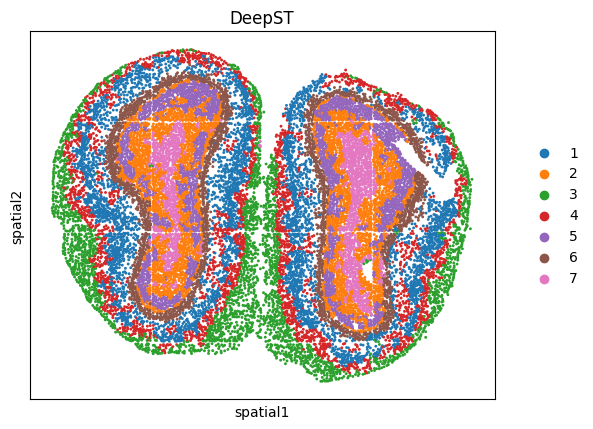

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sc.pl.spatial(adata, color='DeepST_refine_domain', title='DeepST', spot_size=40, show=False, ax=ax)
ax.invert_yaxis()

handles, labels = ax.get_legend_handles_labels()
new_labels = [str(int(label) + 1) if label.isdigit() else label for label in labels]
ax.legend(handles, new_labels, loc='center left',
          bbox_to_anchor=(1.0, 0.5), frameon=False) 
plt.savefig(os.path.join(save_path, f'clustering.pdf'), bbox_inches='tight', dpi=300)

In [16]:
adata.obs

,leiden,DeepST_domain,DeepST_refine_domain,DeepST,x,y
Spot_1,2,2,2,2,12555.007833,6307.537859
Spot_10,2,2,2,2,12806.715054,6311.983871
Spot_100,2,2,2,2,12752.469565,6425.617391
Spot_1000,3,3,3,3,12545.601942,6856.786408
Spot_10000,2,2,2,2,12993.429134,9153.204724
...,...,...,...,...,...,...
Spot_9994,2,2,2,2,14127.819588,9148.005155
Spot_9995,2,2,2,2,12933.872611,9147.484076
Spot_9996,2,2,2,2,13328.963303,9155.389908
Spot_9998,2,2,2,2,12637.854167,9150.281250


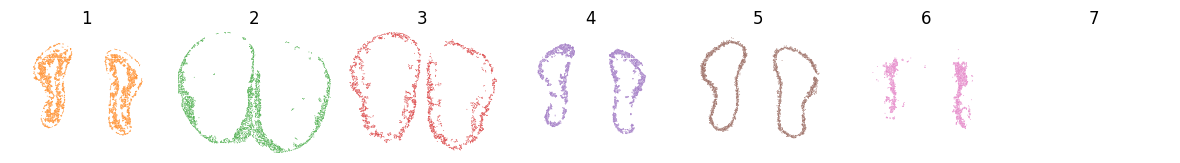

In [23]:
fig, axes = plt.subplots(1,n_domains,figsize=(1.7*n_domains, 1.5*2), sharex=True, sharey=True)
axes = axes.ravel()

for i in range(n_domains):
    sub = adata[adata.obs['DeepST'] == i]
    sc.pl.spatial(sub, spot_size=30, color='DeepST_refine_domain', ax=axes[i], legend_loc=None, show=False)
    axes[i].set_title(i+1)
    
xmin = adata.obsm['spatial'][:, 0].min()
xmax = adata.obsm['spatial'][:, 0].max()
ymin = adata.obsm['spatial'][:, 1].min()
ymax = adata.obsm['spatial'][:, 1].max()

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    
plt.subplots_adjust(wspace=0, hspace=0.05)
plt.tight_layout()
plt.savefig(os.path.join(save_path, f'each_cluster.pdf'), bbox_inches='tight', dpi=300)

In [24]:
cell_metadata = adata.obs
cell_metadata

,leiden,DeepST_domain,DeepST_refine_domain,DeepST,x,y
Spot_1,2,2,2,2,12555.007833,6307.537859
Spot_10,2,2,2,2,12806.715054,6311.983871
Spot_100,2,2,2,2,12752.469565,6425.617391
Spot_1000,3,3,3,3,12545.601942,6856.786408
Spot_10000,2,2,2,2,12993.429134,9153.204724
...,...,...,...,...,...,...
Spot_9994,2,2,2,2,14127.819588,9148.005155
Spot_9995,2,2,2,2,12933.872611,9147.484076
Spot_9996,2,2,2,2,13328.963303,9155.389908
Spot_9998,2,2,2,2,12637.854167,9150.281250


In [25]:
cell_metadata.to_csv(os.path.join(save_path, 'cell_metadata.csv'))